<img src="../../img/eea_grid_assignment.png" alt="EEA Grid Assignment" style="width: 100%; border-radius: 20px;"/>

## Objective
To discretize the latitude-longitude information of each bird sighting, we aim to assign each sighting to a grid cell of the official EEA-Grid for Europe. The discretization is necessary to cap the number of possible bird species-date-location pairs for the subsequent Emergent Filter modeling. <br>
Additionally, we anticipate the following benefits from this discretization:
- **Reduction of Computational Cost:** Instead of calculating features for each location specifically, we can calculate the features for each grid and match the bird sightings based on grids they fall into, which is computationally less demanding.
- **Minimize inaccuracies in bird sighting locations:** Some bird sightings are recorded with an accuracy of approximately 1 square kilometer, leading to inaccuracies when relying on the provided location. Even if the location is precise, the observer might report their own position, which could be in some distance from the actual bird. Expanding the geospatial area of interest for each bird sighting allows for a more comprehensive perspective, addressing potential discrepancies in observer-reported locations.
- **Improved model generalization by reducing sensitivity to small variations:** Assigning sightings to a grid can help in generalizing patterns and trends. It allows to capture broader spatial relationships rather than focusing on specific point locations. 

## Scope
The starting point of this notebook is the merged dataset that includes bird sightings from Switzerland and Germany, which has been reduced to 27 species in *02_Dataset_Reduction_27_species.ipynb*. In this notebook, each data point in this dataset is assigned to an EEA grid, and this assignment is stored as an additional feature.<br>
Based on a recommendation of @Jerôme, we use the reference grid of the European Environment Agency (EEA). It is a standardized and commonly applied grid system used to facilitate the spatial analysis and reporting of environmental data across European countries. Online ([here](https://www.eea.europa.eu/en/datahub/datahubitem-view/3c362237-daa4-45e2-8c16-aaadfb1a003b)), grid sizes of 1km, 10km, 50km and 100km are available. As a compromise between grid size, number of species per grid, and computational complexity, we have chosen a grid size of 50x50km. The 50x50km version is also the most recent iteration, being published in 2018.

## Output data

You can download the resulting dataset *selected_bird_species_with_grids_50km.csv* [here](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e).<br>

In [2]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

In [3]:
import pandas as pd
import geopandas as gpd
import geojson

import plotly.express as px
import plotly.graph_objects as go

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following files are required:
- Master dataset reduced to 27 species: *[master_bird_data_selected_species.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*
- Shapefile of 50x50km EEA grids of Europe: *[eea_50_km_ref-grid-europe/inspire_compatible_grid_50km.shp](https://drive.google.com/drive/folders/1atS5eomHYxX-q_5b8WGqFVDtqP3-d8qP)*

If you wish to store the resulting dataset, please specify a target path where it should be stored.

In [4]:
data_path = '../../../01_Data/datasets/master_bird_data_selected_species.csv'  # Provide path to csv file 'master_bird_data_selected_species.csv'
eea_shapefile_path = '../../../01_Data/shp_files/grids/eea_europe_grids_50km/inspire_compatible_grid_50km.shp'  # Provide path to shp file inside the shapefile folder (e.g. 'path/eea_50_km_ref-grid-europe/inspire_compatible_grid_50km.shp')

target_path = 'selected_bird_species_with_grids_50km.csv'  # Provide path where the csv file should be saved

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>

## Bird sightings

In [5]:
df = pd.read_csv(data_path, index_col=0, low_memory=False)
df.head()

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country
14,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,0,0.0,NaN,37718.0,de
17,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0,2.0,NaN,37803.0,de
30,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,0,2.0,NaN,39627.0,de
49,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,0,8.0,NaN,38301.0,de
77,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,0,10.0,NaN,108167.0,de


## EEA grids
The EEA geopandas dataframe holds the information for all square 50x50km polygons of Europe:

In [6]:
eea_grid = gpd.read_file(eea_shapefile_path)
eea_grid.head()

,cellcode,eoforigin,noforigin,gid,geometry
0,50kmE700N0,700000,0,1,"POLYGON ((700000.000 0.000, 700000.000 50000.0..."
1,50kmE750N0,750000,0,2,"POLYGON ((750000.000 0.000, 750000.000 50000.0..."
2,50kmE800N0,800000,0,3,"POLYGON ((800000.000 0.000, 800000.000 50000.0..."
3,50kmE850N0,850000,0,4,"POLYGON ((850000.000 0.000, 850000.000 50000.0..."
4,50kmE900N0,900000,0,5,"POLYGON ((900000.000 0.000, 900000.000 50000.0..."


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣  Align Coordinate Reference System (CRS) of bird sightings and EEA grids </p>
Initially, it is crucial to ensure that both the bird sightings and the grid cells utilize the same coordinate reference system to enable accurate matching.<br>
The EEA grids are specified in the CRS EPSG:3035:

In [7]:
eea_grid.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

EPSG:3035 is a projected coordinate reference system used for Europe. It is based on the European Terrestrial Reference System 1989 (ETRS89) and uses the Lambert Azimuthal Equal Area (LAEA) projection. This projection minimizes distortion for area measurements but may distort shapes and angles in favor of maintaining accurate area representations.

However, our bird sightings are specified in the CRS WGS84. WGS84 is a global geodetic datum commonly used to represent locations on the Earth's surface using latitude and longitude coordinates. The EPSG code for WGS84 is EPSG:4326.

In order to ensure proper alignment, we need to perform a coordinate transformation of the EEA grids to EPSG:4326 (WGS84):


In [8]:
eea_grid = eea_grid.to_crs('EPSG:4326')
eea_grid.head()

,cellcode,eoforigin,noforigin,gid,geometry
0,50kmE700N0,700000,0,1,"POLYGON ((-23.10211 15.84476, -23.22593 16.278..."
1,50kmE750N0,750000,0,2,"POLYGON ((-22.66889 16.03070, -22.79169 16.465..."
2,50kmE800N0,800000,0,3,"POLYGON ((-22.23489 16.21425, -22.35664 16.649..."
3,50kmE850N0,850000,0,4,"POLYGON ((-21.80011 16.39541, -21.92078 16.831..."
4,50kmE900N0,900000,0,5,"POLYGON ((-21.36453 16.57416, -21.48410 17.010..."


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣  Assign an EEA grid cell to each datapoint in our ornitho dataset </p>
Prior to matching each bird sighting to an EEA grid cell, we shrink the Area of Interest by reducing the EEA grid so that only German and Swiss grids are left. This significantly speeds up the assignment process<br>


In [9]:
germany_switzerland_bbox = eea_grid.cx[5.210942:15.669926, 45.614516:55.379499]
eea_grid_filtered = eea_grid[eea_grid.intersects(germany_switzerland_bbox.unary_union)]
eea_grid_filtered.reset_index(drop=True, inplace=True)

Now, the coordinates of each bird sighting are assigned to a grid and noted in a new column in the dataset. To do so, we perform a spatial join operation to joint the datapoints and the grids based on their spatial relationship (points being within polygons).<br>

In [10]:
geometry = gpd.points_from_xy(df['coord_lon'], df['coord_lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

joined_gdf = gpd.sjoin(gdf, eea_grid_filtered, how='left', predicate='within')
joined_gdf.rename(columns={'cellcode': 'eea_grid_id'}, inplace=True)
result_gdf = joined_gdf.drop(columns=['index_right', 'geometry', 'noforigin', 'eoforigin', 'gid'])

In the resulting geo-dataframe there is now another column `eea_grid_id` which assigns each point to a polygon of size 50x50km:

In [11]:
result_gdf

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
14,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,0,0.0,NaN,37718.0,de,50kmE4200N3300
17,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0,2.0,NaN,37803.0,de,50kmE4250N3300
30,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,0,2.0,NaN,39627.0,de,50kmE4450N3050
49,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,0,8.0,NaN,38301.0,de,50kmE4350N3100
77,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,0,10.0,NaN,108167.0,de,50kmE4100N3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9922826,27523548,469.0,Bergpieper,2022-08-01,09:35:04,46.563896,8.551648,precise,2085,4.0,0,11482.0,ch,50kmE4200N2600
9922833,27523686,338.0,Mittelspecht,2022-10-08,09:17:16,47.383318,7.666533,precise,798,1.0,0,11482.0,ch,50kmE4100N2650
9922862,15002272,123.0,Bergente,2018-02-17,NaN,47.512154,9.436332,precise,390,1.0,0,11245.0,ch,50kmE4250N2700
9922867,15002282,8.0,Haubentaucher,2018-02-17,NaN,47.512154,9.436332,precise,390,NaN,0,11245.0,ch,50kmE4250N2700


We also check if any bird sighting could not be assigned to a grid by checking if there are any NaN values in that column. As we can see, all bird sightings could be assigned to a respective EEA grid:

In [12]:
result_gdf.eea_grid_id.isna().any().any()

False

Finally, we store the new dataframe to a csv-file.

In [13]:
result_gdf.to_csv(target_path)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 4️⃣  Verify correctness of grid assignments </p>

To show that the bird sightings are indeed located in the corresponding assigned grid, the first 20 data points are plotted alongside their grid as an example. As can be seen, all data points lie within the grid selected for them.

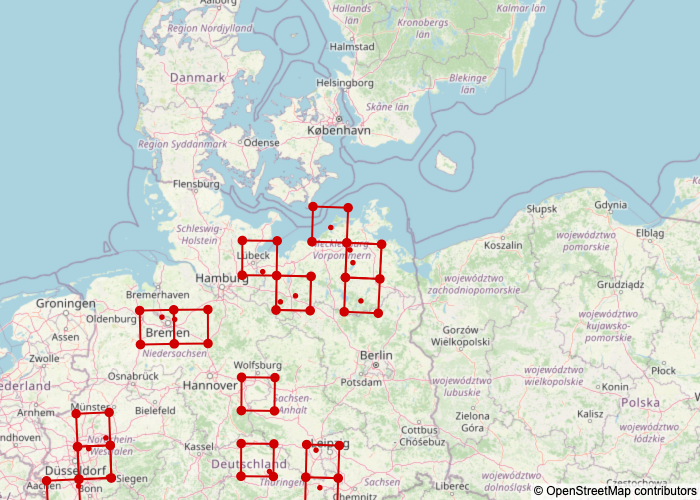

In [14]:
layout = go.Layout(
        mapbox=dict(
            style='open-street-map',
            zoom=10), showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig = go.Figure(layout=layout)

for i in range(0,21):
    # Get bird sighting
    bird_sighting = result_gdf.iloc[i].copy()
    bird_sighting['color'] = '#d00000'
    geometry = gpd.points_from_xy([bird_sighting['coord_lon']], [bird_sighting['coord_lat']])
    gdf_data_point = gpd.GeoDataFrame([bird_sighting], geometry=geometry, crs='EPSG:4326')

    # Get polygon assigned to that bird sighting
    eea_grid_id = bird_sighting['eea_grid_id']
    polygon = eea_grid_filtered[eea_grid_filtered['cellcode'] == eea_grid_id]['geometry'].iloc[0]
    geojson_polygon = geojson.Feature(geometry=polygon, properties={})

    # Add polygon to map
    fig.add_trace(trace = go.Scattermapbox(
        lon=[lon for lon, lat in geojson_polygon['geometry']['coordinates'][0]],
        lat=[lat for lon, lat in geojson_polygon['geometry']['coordinates'][0]],
        mode='markers+lines',
        marker=dict(size=10, color='#d00000')))

    # Add point to map
    fig.add_trace(px.scatter_mapbox(gdf_data_point,
                    lat='coord_lat', lon='coord_lon', hover_name='eea_grid_id', size_max=10, color_discrete_sequence=[gdf_data_point.color]).data[0])

# Show the plot
fig.update_layout(mapbox_style='open-street-map', mapbox_zoom=5,
                    mapbox_center={'lat': bird_sighting['coord_lat'], 'lon': bird_sighting['coord_lon']})
fig.show()